### Previsone 1 Step per serie multivariata usando MLP 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from keras import metrics

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_2 = agg_by_cell.get_group('486-1256')
cell_3 = agg_by_cell.get_group('486-1258')
# define input sequence
series1 = cell_1['nr_people'].values
series2 = cell_2['nr_people'].values
series3 = cell_3['nr_people'].values
print(type(series2))

<class 'numpy.ndarray'>


In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))]) # convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))
print(dataset.shape)
# choose a number of time steps
n_steps = 4
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# summarize the data
count = 0
for i in range(len(X)):
    count += 1
    if count > 2: break
    print(X[i], y[i])

(11808, 4)
[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]


### Dividi dataset in Train-validation-test

In [3]:
# split into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))

count = 0
for i in range(len(X)):
    print(train_X[i],train_y[i])
    count +=1
    if count >= 3:
        break

5783 5783 3542 3542 2479 2479
[[ 59.  71.  49. 179.]
 [ 59.  71.  49. 179.]
 [ 59.  71.  48. 178.]
 [ 59.  71.  48. 178.]] [ 59.  71.  49. 179.]
[[ 32.  37.  37. 106.]
 [ 32.  37.  37. 106.]
 [ 32.  36.  37. 105.]
 [ 34.  38.  37. 109.]] [ 34.  38.  37. 109.]
[[ 57.  70.  45. 172.]
 [ 55.  66.  44. 165.]
 [ 55.  66.  44. 165.]
 [ 52.  63.  42. 157.]] [ 51.  61.  42. 154.]


In [4]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
n_output = train_y.shape[1]
print(len(train_X))

5783


In [5]:
# flatten input
n_input_test = test_X.shape[1] * test_X.shape[2]
test_X = test_X.reshape((test_X.shape[0], n_input_test))
n_output_test = test_y.shape[1]



In [13]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output_test))
model.compile(optimizer='adam', loss='mse', metrics=[metrics.mae, 'accuracy'])
# fit model
model.fit(train_X, train_y, epochs=200, verbose=2)

Epoch 1/200
 - 0s - loss: 325.7128 - mean_absolute_error: 8.0935 - accuracy: 0.9604
Epoch 2/200
 - 0s - loss: 30.8123 - mean_absolute_error: 4.0312 - accuracy: 1.0000
Epoch 3/200
 - 0s - loss: 21.9790 - mean_absolute_error: 3.2957 - accuracy: 1.0000
Epoch 4/200
 - 0s - loss: 16.3484 - mean_absolute_error: 2.7536 - accuracy: 1.0000
Epoch 5/200
 - 0s - loss: 12.3264 - mean_absolute_error: 2.3516 - accuracy: 1.0000
Epoch 6/200
 - 0s - loss: 9.8711 - mean_absolute_error: 2.1076 - accuracy: 1.0000
Epoch 7/200
 - 0s - loss: 8.5138 - mean_absolute_error: 1.9636 - accuracy: 1.0000
Epoch 8/200
 - 0s - loss: 7.9180 - mean_absolute_error: 1.9033 - accuracy: 1.0000
Epoch 9/200
 - 0s - loss: 7.3714 - mean_absolute_error: 1.8425 - accuracy: 1.0000
Epoch 10/200
 - 0s - loss: 7.1049 - mean_absolute_error: 1.8073 - accuracy: 1.0000
Epoch 11/200
 - 0s - loss: 7.0619 - mean_absolute_error: 1.7976 - accuracy: 1.0000
Epoch 12/200
 - 0s - loss: 7.0336 - mean_absolute_error: 1.7797 - accuracy: 1.0000
Epoch 1

Epoch 100/200
 - 0s - loss: 5.6818 - mean_absolute_error: 1.5457 - accuracy: 1.0000
Epoch 101/200
 - 0s - loss: 5.6646 - mean_absolute_error: 1.5384 - accuracy: 1.0000
Epoch 102/200
 - 0s - loss: 5.6796 - mean_absolute_error: 1.5391 - accuracy: 1.0000
Epoch 103/200
 - 0s - loss: 5.7026 - mean_absolute_error: 1.5452 - accuracy: 1.0000
Epoch 104/200
 - 0s - loss: 5.7494 - mean_absolute_error: 1.5572 - accuracy: 1.0000
Epoch 105/200
 - 0s - loss: 5.7312 - mean_absolute_error: 1.5537 - accuracy: 1.0000
Epoch 106/200
 - 0s - loss: 5.7288 - mean_absolute_error: 1.5479 - accuracy: 1.0000
Epoch 107/200
 - 0s - loss: 5.6238 - mean_absolute_error: 1.5300 - accuracy: 1.0000
Epoch 108/200
 - 0s - loss: 5.5753 - mean_absolute_error: 1.5202 - accuracy: 1.0000
Epoch 109/200
 - 0s - loss: 5.6481 - mean_absolute_error: 1.5389 - accuracy: 1.0000
Epoch 110/200
 - 0s - loss: 5.7631 - mean_absolute_error: 1.5585 - accuracy: 1.0000
Epoch 111/200
 - 0s - loss: 5.6068 - mean_absolute_error: 1.5279 - accuracy:

Epoch 198/200
 - 0s - loss: 5.5366 - mean_absolute_error: 1.5085 - accuracy: 1.0000
Epoch 199/200
 - 0s - loss: 5.5496 - mean_absolute_error: 1.5163 - accuracy: 1.0000
Epoch 200/200
 - 0s - loss: 5.6701 - mean_absolute_error: 1.5329 - accuracy: 1.0000


### Calcolo dell'errore

In [14]:
# compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_input_test))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0])   

expected = test_y  

print(len(expected))
print(len(predicted))
expected = np.reshape(expected, predicted.shape[0])

# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))


3542
14168
Mean Absolute Error =  1.5533870667942764


### Grafico distribuzione errore

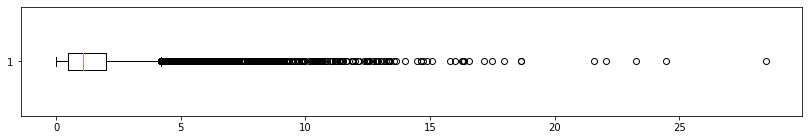

In [15]:
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);

### Fermare il traning al momento giusto 

In [10]:
# import EarlyStopping
from keras.callbacks import EarlyStopping
# import metrics
from keras import metrics

# define model
model = Sequential()
model.add(Dense(500, input_dim=n_steps * n_steps, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=[metrics.mae, 'accuracy'])

# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=4000, verbose=0, callbacks=[es]) 

# evaluate the model
train_acc = model.evaluate(train_X, train_y, verbose=1)

val_acc = model.evaluate(val_X, val_y, verbose=1)
print(train_acc, val_acc)
print(model.metrics_names)
print('Train: %.3f, Val: %.3f' % (train_acc[2], val_acc[2]))
print(model.metrics_names)
# plot loss learning curves
plt.figure(figsize = (15, 8))
plt.subplot(211)
plt.title('MSE Loss', pad=-40)
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val')
plt.legend()

# plot accuracy learning curves
plt.subplot(212)
plt.title('Accuracy', pad=-40)
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

ValueError: Error when checking target: expected dense_6 to have shape (1,) but got array with shape (4,)